# Clustering of Stock Price Data using GMM

# Introduction 

Analysing stock price time series comes with various challenges. One of them is the question of whether stock prices behave similarly depending on the economic sectors and industries.
I investigate whether we can employ unsupervised clustering on the development of stock price over time.

The results using GMM are less promising than expected. 

Nonetheless, this article may provide interested readers with useful ideas for their own investigations.

## Growth Mixture Model (GMM)

GMM is a probabilistic latent variable growth method that attempts to find a mixture of multidimensional Gaussian probability distributions that model the input dataset [6, p. 776]. 
It differs from basic growth models in that it observes the underlying sub-populations [3]. It is usually employed in health science since it is “considered to be a person-centred method because it is predicated on the assumption that people are the agents that affect the outcomes of interest with predictor variables deemed to be properties of those people” [4].

Thus, one aim of this article is to investigate whether GMM can be employed on non-person related longitudinal data such as stock prices. A motivation for this experiment is that parts of the literature indicate that GMM can be used to represent any data set that can be clustered into multiple Gaussian distributions since the algorithm estimates the parameters of the Gaussian distribution of the different clusters [5].

> It is important to consider that GMM is not a clustering method in the strict sense, but rather an algorithm for density estimation. A concise description of the ‘mechanics’ of GMM can be found in the respective  Wikipedia article. In short, it selects starting guesses for the location and shape. Then, iteratively, it finds the weights unwrapping the probability of membership in each cluster (E-step) and updates the location, normalisation and shape of the clusters based on all data points (M-step) [6, p. 784]

### Data

Half-hourly share price data is generated through Financial Modelling Prep’s API. I provide these data in the respository’s “data.csv” file, with its

- columns: 333 consecutive datapoints covering half-hourly stock price data (usually between 9am and 16pm the same day) ranging from 13 February 2023 to 17 March 2023. The column names are anonymised.

- observations (rows): 473 shares along 4 selected industries (Technology’ Basic Materials, Industrials, Consumer Cyclical). The stock symbols (tickers) are anonymised.

- values: Log returns of the open/close prices (each measured with one time lag).

Due to different availability of the data the conversion to log prices produces NaNs. These were filled with zeros, since with no trading of the respective stocks, the log return in the next time lag is zero. 

The sectors the companies belong to are mapped in a seperate csv file “sectors.csv”.

In [26]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets._samples_generator import make_blobs
from sklearn import metrics

df_in = pd.read_csv('data.csv', index_col=0)
df_in.head()

,symbol,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,575,-0.001137,0.008527,-0.005808,-0.003630,0.010863,0.005933,-0.002473,0.002579,-0.001755,...,-0.012214,-0.003507,0.003961,0.001404,-0.006647,0.001274,0.009193,-0.002167,-0.006118,0.001938
1,537,0.010103,-0.001521,-0.001524,0.003354,0.005616,0.001217,-0.001517,0.002732,-0.000304,...,-0.019349,-0.005060,-0.004344,0.002893,-0.001817,-0.001446,0.001454,-0.003252,0.010388,0.011544
2,649,0.010156,0.003907,-0.006261,-0.002778,0.005568,0.001522,-0.002581,0.001057,0.000497,...,-0.000754,0.001300,0.003704,0.007972,0.000918,-0.009861,-0.009649,-0.009703,0.000843,0.015026
3,1,0.009744,0.002821,0.005121,0.005097,0.005989,0.002376,-0.000714,0.001137,-0.003807,...,-0.004954,-0.003002,0.000000,0.003549,0.001353,0.002059,0.003372,-0.003671,-0.005664,0.000903
4,132,0.005622,0.000148,0.001327,0.002505,0.001913,0.000883,0.001291,0.002204,-0.001176,...,-0.000938,0.000469,0.001251,-0.002692,-0.002502,0.002817,0.001564,0.000000,0.000000,0.000000


### Scale values

In [29]:
from sklearn.preprocessing import StandardScaler
def scale(df, symbols):
    scale = StandardScaler()
    if 'symbol' in df.columns:
        df = df.iloc[:,1:]
    arr_scaled = scale.fit_transform(df)
    df_scaled = pd.DataFrame(arr_scaled)
    df_scaled.insert(loc=0, column='symbol', value=symbols) # Insert ticker column
    return(df_scaled)
df_scaled = scale(df_in, symbols=df_in.symbol)
df_sectors = pd.read_csv('sectors.csv', index_col=0) # Add sectors for train/test split
df_scaled = pd.merge(df_scaled, df_sectors, left_on='symbol', right_on='symbol_anonymised')
df_scaled.head()

,symbol,0,1,2,3,4,5,6,7,8,...,324,325,326,327,328,329,330,331,332,sector
0,575,-0.648018,0.950573,-1.278249,-0.424756,1.308712,1.029614,-0.784523,0.093321,-0.167799,...,0.235687,0.941589,-0.182861,-1.645517,0.180078,1.471469,0.088403,-0.909620,-0.210074,Basic Materials
1,537,0.531791,-0.798194,-0.640297,0.310759,0.550993,0.012219,-0.576396,0.124944,0.120949,...,0.020983,-0.641875,0.123572,-0.620200,-0.499707,-0.017904,-0.131772,2.665136,1.640602,Industrials
2,649,0.537435,0.146508,-1.345765,-0.335097,0.544121,0.077932,-0.808148,-0.222339,0.280198,...,0.900275,0.892432,1.168409,-0.039459,-2.602787,-2.154642,-1.440953,0.597831,2.311504,Consumer Cyclical
3,1,0.494101,-0.042419,0.349378,0.494310,0.604832,0.262265,-0.401481,-0.205700,-0.575930,...,0.305458,0.186302,0.258558,0.052871,0.376225,0.351244,-0.216853,-0.811402,-0.409514,Technology
4,132,0.061490,-0.507811,-0.215704,0.221325,0.016416,-0.059846,0.035204,0.015456,-0.052533,...,0.785310,0.424777,-1.025505,-0.765566,0.565702,0.003303,0.528106,0.415330,-0.583472,Industrials


In [44]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_scaled, stratify=df_scaled.sector)

Train / test split

### Feature production

The cesium library provides distribution statistics to the observations. It is mostly used in health science. As it appears to apply an agnostic approach to time series I make use of it to generate a number of features:

In [53]:
from cesium import featurize as ft
times = []
log_return_values = []
for idx, row in df_train.iloc[:,1:-1].iterrows():
    log_return_values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

fs = ['amplitude',
                   'percent_beyond_1_std',
                   'max_slope',
                   'percent_close_to_median',
                   'weighted_average',
                   'maximum',
                   'minimum',
                   'median',
                   'skew']

df_features = ft.featurize_time_series(
                    times           = times,
                    values          = log_return_values,
                    errors          = None,
                    features_to_use = fs,
                    scheduler       = None)

# Remove multihead, scale and put 'back' headers
df_features = df_features.T.reset_index().drop(['channel'], axis=1).iloc[:,1:].T
df_features_scaled = scale(df_features, symbols=df_in.symbol)
df_features_scaled = df_features_scaled.rename(columns={0:fs[0], 1:fs[1], 2:fs[2], 
                    3:fs[3], 4:fs[4], 5:fs[5], 6:fs[6], 7:fs[7], 8:fs[8]}) 
df_features_scaled

,symbol,amplitude,percent_beyond_1_std,max_slope,percent_close_to_median,weighted_average,maximum,minimum,median,skew
0,575,-0.698143,1.309245,-0.675529,-0.918719,0.792393,-0.505400,0.710399,0.606552,0.114939
1,537,0.040447,-0.787167,-0.106158,0.481517,3.245659,0.349804,0.286305,1.838974,0.970994
2,649,1.641772,-0.660111,1.543751,0.722183,-2.776779,1.953682,-0.888861,-1.615207,0.114020
3,1,-0.369626,-0.024835,-0.416339,-0.043571,-0.321654,-0.568824,0.068349,-0.576860,-0.103614
4,132,1.855414,-2.184774,2.563161,1.291029,-1.574376,0.823302,-2.419109,-1.463375,-1.497970
...,...,...,...,...,...,...,...,...,...,...
348,189,-0.518890,-0.278946,-0.764696,-0.174844,-0.182938,-0.515276,0.385337,-0.111426,-0.094900
349,536,-0.403219,1.436300,-0.214861,-1.400050,0.521588,-0.505979,0.191583,1.748071,-0.205365
350,872,-0.483186,-0.088363,-0.226404,0.590911,0.483374,-0.757114,0.075525,0.846429,-0.628716
351,686,0.177737,-0.151890,0.452346,0.612789,-0.415122,-0.444927,-0.766868,-0.034734,-0.817311


,amplitude,percent_beyond_1_std,max_slope,percent_close_to_median,weighted_average,maximum,minimum,median,skew
symbol,,,,,,,,,
575,-0.698143,1.309245,-0.675529,-0.918719,0.792393,-0.505400,0.710399,0.606552,0.114939
537,0.040447,-0.787167,-0.106158,0.481517,3.245659,0.349804,0.286305,1.838974,0.970994
649,1.641772,-0.660111,1.543751,0.722183,-2.776779,1.953682,-0.888861,-1.615207,0.114020
1,-0.369626,-0.024835,-0.416339,-0.043571,-0.321654,-0.568824,0.068349,-0.576860,-0.103614
132,1.855414,-2.184774,2.563161,1.291029,-1.574376,0.823302,-2.419109,-1.463375,-1.497970
...,...,...,...,...,...,...,...,...,...
189,-0.518890,-0.278946,-0.764696,-0.174844,-0.182938,-0.515276,0.385337,-0.111426,-0.094900
536,-0.403219,1.436300,-0.214861,-1.400050,0.521588,-0.505979,0.191583,1.748071,-0.205365
872,-0.483186,-0.088363,-0.226404,0.590911,0.483374,-0.757114,0.075525,0.846429,-0.628716


### GMM 

As explained above, GMM is an algorithm for density estimation, in contrast cluster methods such as k-means. For the choice of appropriate hyperparameters this means that:

- the number of components does not necessarily need to match the shape of the different clusters, but can rather be 'grouped' around the points resulting from GMM. Therefore, the model will be prone to overfitting. Below we loop through choices 2–30 for components.

- my experiments indicate that the covariance type appears crucial. From the 4 choices (tied, full, diag, spherical) 'diag' appears best for the data at hand. See the scikit-Learn GMM documentation for the details on these parameters. This is illustrated according to the documentation on model selection:

In [96]:
from sklearn.model_selection import GridSearchCV
X = df_features
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return estimator.bic(X)

def gmm_aic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the AIC score."""
    return estimator.aic(X)

def plot_model_grids(X, criterion_type, max_params=25):
    param_grid = {
        "n_components": range(1, max_params),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
    score_func_name = ''
    if criterion_type == 'aic':
        score_func_name = gmm_aic_score
    else:
        score_func_name = gmm_bic_score
    grid_search = GridSearchCV(
        GMM(), param_grid=param_grid, scoring=score_func_name
    )
    grid_search.fit(X)

    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
    df["mean_test_score"] = -df["mean_test_score"]
    df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "score",
        }
    )
    df.sort_values(by="score").head()

    import seaborn as sns

    sns.catplot(
        data=df,
        kind="bar",
        x="Number of components",
        y="score",
        hue="Type of covariance",
    )
    plt.show()

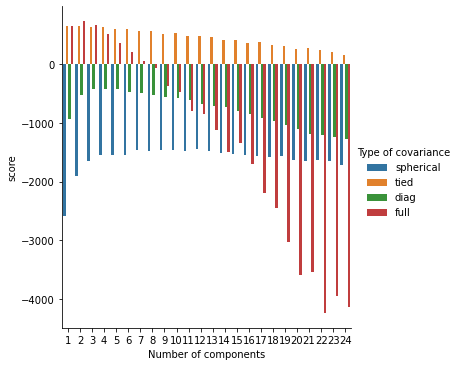

In [97]:
plot_model_grids(df_features, 'aic')

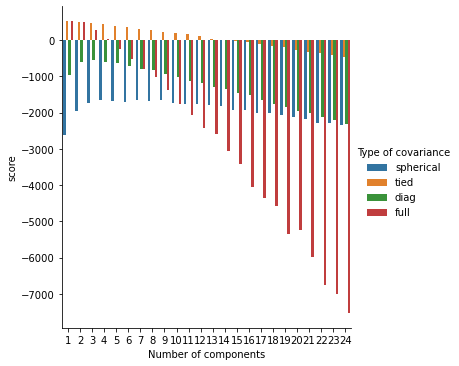

In [98]:
plot_model_grids(df_features, 'bic')

In [85]:
components_range = range(2,30,1)

def run_model(df, covariance_type):
    X = np.array(df)
    models = []
    bics = []
    aics = []
    for cl in components_range:
        model = GMM(n_components=cl, random_state=0, covariance_type=covariance_type)
        models.append(model)
        fit = model.fit(X)
        labels = fit.predict(X)
        bics.append(fit.bic(X))
        aics.append(fit.aic(X))
    return(bics, aics)

The 'Full' covariance type quickly draws to (large) positive values whereas 'diag' varies much less. This does not necessarily mean that the 'diag' models are robust.

## Conclusion and outlook

Against my initial exploration of the data and model the results look rather promising for GMM being a choice for further investigations.

I hope this article is informative. Your feedback is warmly welcome!

## Sources

[1] Taushanov, Zh., Ghisletta, P.: The Use of a Hidden Mixture Transition Distribution Model in Clustering Few but Long Continuous Sequences: An Illustration with Cognitive Skills Data', research article, University of Geneva, September 2020

[2] Nielsen, A.: Practical Time Series Analysis, O'Reilly Media, 2020

[3] Ram, N; Grimm, K.J.: Growth Mixture Modeling: A Method for Identifying Differences in Longitudinal Change Among Unobserved Groups; Int J Behav Dev. 2009; 33(6): 565–57, July 2022

[4] Kwon, JY., Sawatzky, R., Baumbusch, J. et al.: Growth mixture models: a case example of the longitudinal analysis of patient‐reported outcomes data captured by a clinical registry, MC Med Res Methodol 21, 79 (2021). https://doi.org/10.1186/s12874-021-01276-z

[5] Kumar, A.: Gaussian Mixture Models: What are they & when to use?, blog post, April 2022

[6] VanderPlas, J.: Python Data Science Handbook, second edition, O'Reilly media, 2023